# **Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [173]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import glob
import numpy as np
from moviepy.editor import VideoFileClip
%matplotlib inline

In [174]:
def showImage(image):
    plt.imshow(image); plt.axis('off'); plt.show();
    
def showImages(images):
    num_y = int(len(images)/3) + 1
    fig = plt.figure(figsize = (10, len(images)*2))
    grid = gridspec.GridSpec(num_y, 3, wspace = 0.1, hspace = 0.1, width_ratios=np.ones(shape=(3)), height_ratios=np.ones(shape=(len(images))))
    for i, image in enumerate(images):
        subp = plt.subplot(grid[i])
        subp.imshow(image)
        plt.axis('off')
        fig.add_subplot(subp)
    plt.show();

def renderImages(images):
    num_y = int(len(images)/3) + 1
    fig = plt.figure(figsize = (10, len(images)*2))
    grid = gridspec.GridSpec(num_y, 3, wspace = 0.1, hspace = 0.1, width_ratios=np.ones(shape=(3)), height_ratios=np.ones(shape=(len(images))))
    for i, image in enumerate(images):
        subp = plt.subplot(grid[i])
        subp.imshow(image)
        plt.axis('off')
        fig.add_subplot(subp)
    
    plt.savefig ( "./latest.png" )
    return(cv2.imread("./latest.png"))

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation. 

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

Original Images


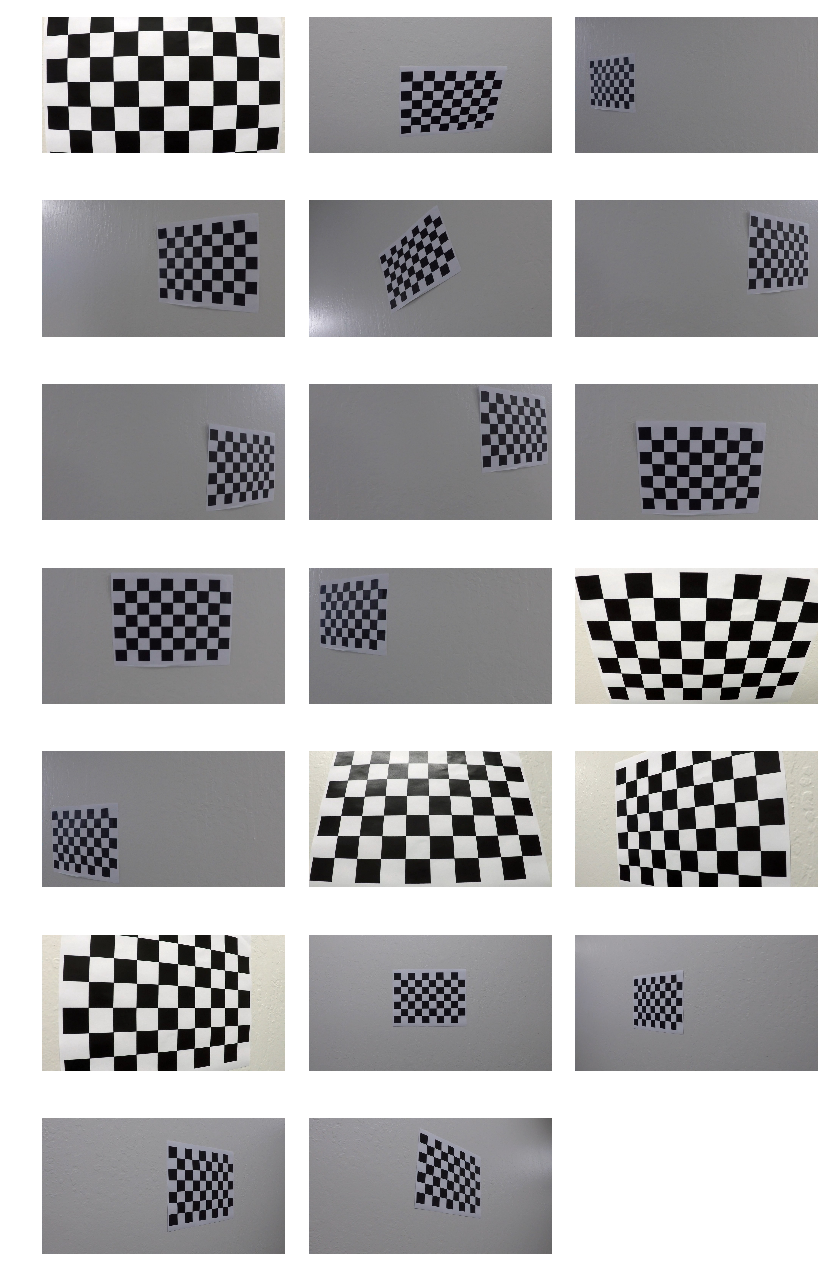

Detected Corners


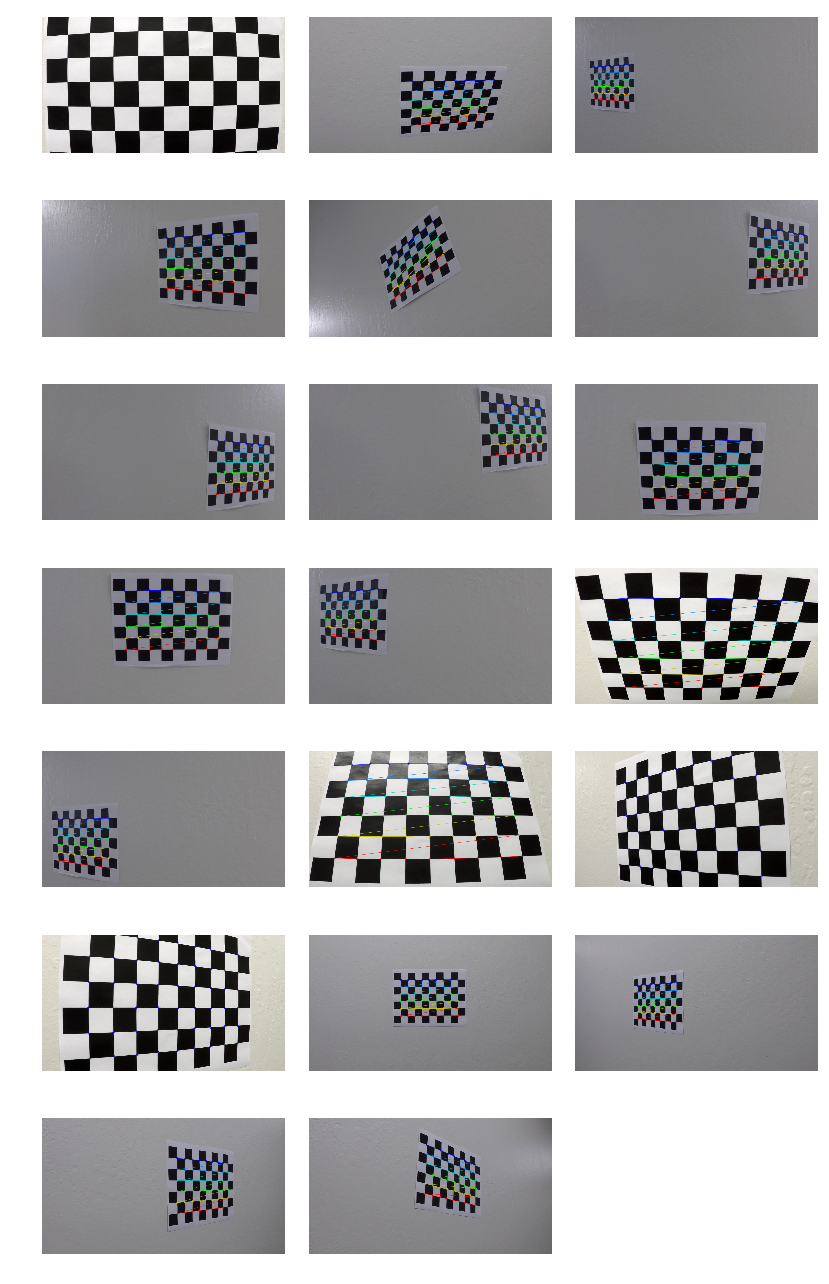

In [175]:
dims = (9,6)
calibration_images = [mpimg.imread(file) for file in glob.glob("./camera_cal/calibration*.jpg")]
grey_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in calibration_images]
chessboard_corners = [cv2.findChessboardCorners(image, dims, None) for image in grey_images]
print("Original Images")
showImages(calibration_images)

[cv2.drawChessboardCorners(calibration_images[i], dims, *chessboard_corners[i][::-1]) for i in range(len(calibration_images))]
print("Detected Corners")
showImages(calibration_images)

In [176]:
objp = np.zeros((np.prod(dims), 3), np.float32)
objp[:,:2] = np.mgrid[0:dims[0], 0:dims[1]].T.reshape(-1,2)

objpoints = [objp for corner_set in chessboard_corners if corner_set[0]]
imgpoints = [corner_set[1] for corner_set in chessboard_corners if corner_set[0]]



I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

Undistorted images


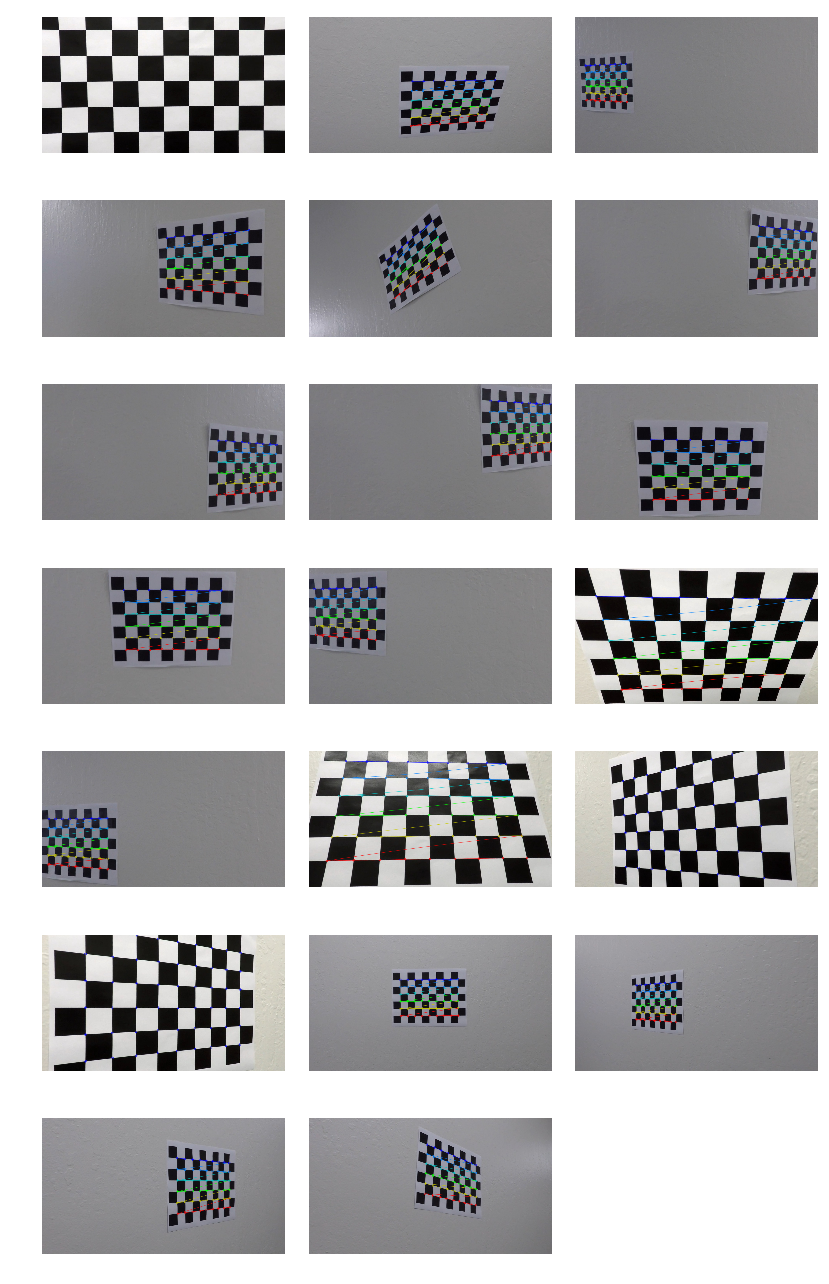

In [177]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grey_images[0].shape[::-1], None, None)
# Undistort the images
undistorted_images = [cv2.undistort(image, mtx, dist, None, mtx) for image in calibration_images]
print("Undistorted images")
showImages(undistorted_images)

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

before:


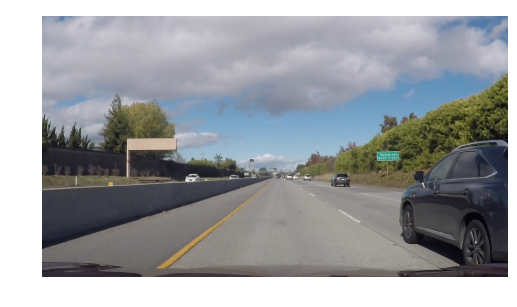

after:


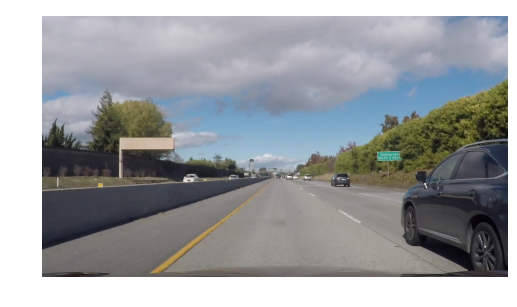

In [178]:
print("before:")
showImage(plt.imread("roadImg.png"))
print("after:")
showImage(cv2.undistort(plt.imread("roadImg.png"), mtx, dist, None, mtx))

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

In [179]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, hls_sthresh=(0,255), hsv_sthresh=(0,255), hsv_vthresh=(0,255)):
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= hsv_vthresh[0]) & (v_channel <= hsv_vthresh[1])] = 1
    
    #hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hsv[:,:,1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > hsv_sthresh[0]) & (s_channel <= hsv_sthresh[1])] = 1
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s2_channel = hls[:,:,2]
    s2_binary = np.zeros_like(s2_channel)
    s2_binary[(s2_channel > hls_sthresh[0]) & (s2_channel <= hls_sthresh[1])] = 1
     
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1) & (s2_binary == 1)] = 1
    
    return output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level + 1)*height):int(img_ref.shape[0] - level*height), max(0, int(center-width)):min(int(center+width), img_ref.shape[1])] = 1
    return output

In [180]:
img = cv2.undistort(plt.imread("./test_images/test3.jpg"), mtx, dist, None, mtx)
    
preprocessImage = np.zeros_like(img[:,:,0])
    
gradx = abs_sobel_thresh(img, orient='x', thresh_max=225, thresh_min=18)
grady = abs_sobel_thresh(img, orient='y', thresh_max=225, thresh_min=25)
    
mag_th = mag_thresh(img, sobel_kernel=9, mag_thresh=(50, 250))
dir_th = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

white_c_binary = color_threshold(img, hls_sthresh = (88, 255), hsv_sthresh=(0, 70), hsv_vthresh=(160, 255))
yellow_c_binary = color_threshold(img, hls_sthresh = (88, 190), hsv_vthresh=(100, 255))

c_binary = cv2.bitwise_or(yellow_c_binary, white_c_binary)

preprocessImage[((gradx == 1) & (grady == 1)) | ((yellow_c_binary == 1) | ((white_c_binary == 1) & ((mag_th == 1) & (dir_th == 1))))] = 255

Before:


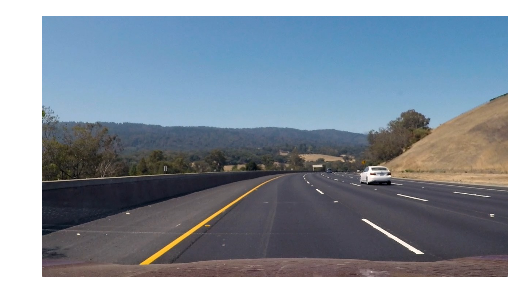

After:


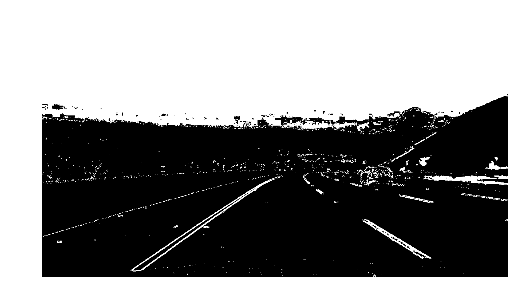

In [204]:
print("Before:")
plt.imshow(plt.imread("./test_images/test3.jpg")); plt.axis('off'); plt.show();
plt.imsave("./output_images/original.jpg", plt.imread("./test_images/test3.jpg"))
print("After:")
plt.imshow(preprocessImage, cmap='gray'); plt.axis('off'); plt.show();
plt.imsave("./output_images/step_1_undistorted.jpg", preprocessImage)

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform is in a function called `warp()`, which appears in the 8th cell (directly under the **Lane Line Detection** header) in the file `Advanced Lane Line Detection.ipynb` IPython notebook.  The `warp()` function takes as inputs an image (`img`), as well as various parameters that help influence the source and destination points.  I originally hardcoded the solution, but found it was hard to tinker with, hence I opted for a solution similar to that presented in the P4 Youtube live Youtube Tutorial.

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 551.08, 417.26      | 168.25, 0        | 
| 646.92, 417.26      | 504.75, 0      |
| 1054.24 , 629.26     | 504.75, 1198      |
| 143.76, 629.26      | 168.25, 1198        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image. (See below)

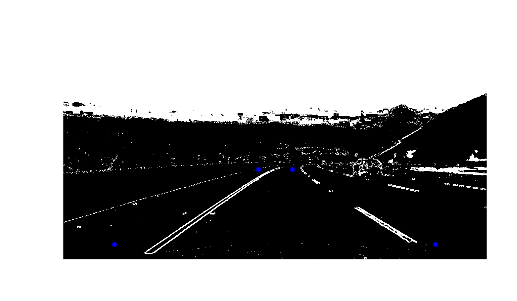

In [205]:
img = preprocessImage
w = img.shape[1]
h = img.shape[0]

bot_width = 0.76
mid_width = 0.08
height_pct = 0.62
bottom_trim = 0.935

src = np.float32([ [w*(0.5 - mid_width/2), h*height_pct],
                   [w*(0.5 + mid_width/2), h*height_pct], 
                   [w*(0.5 + bot_width/2), h*bottom_trim], 
                   [w*(0.5-bot_width/2),   h*bottom_trim]])

plt.imshow(img, cmap='gray'); plt.axis('off')
plt.scatter(src[:,0], src[:,1])

offset = w*.2
dst = np.float32([ [offset, 0], 
                   [w - offset, 0],
                   [w - offset, h], 
                   [offset, h]])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, (w, h), flags = cv2.INTER_LINEAR)

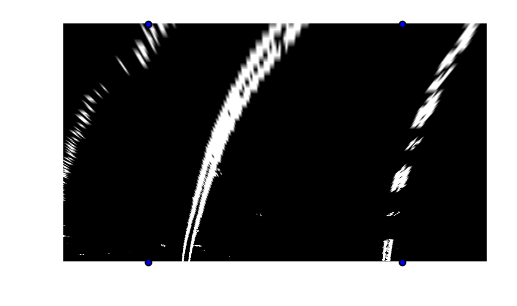

In [207]:
plt.imshow(warped, cmap='gray'); plt.axis('off'); 
plt.scatter(dst[:,0], dst[:,1])
plt.show();
plt.imsave("./output_images/step_2_perspective_transf.jpg", cv2.cvtColor(warped,cv2.COLOR_GRAY2RGB))

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

I detected lane lines from the warped image using a sliding-window-based tracking method (credit: Tutorial Video on P4 by Udacity).
This involves firstly summing the vertical pixel values in the image and identifying the 2 peaks in the histogram, which should give an indication of the location of the lane lines.

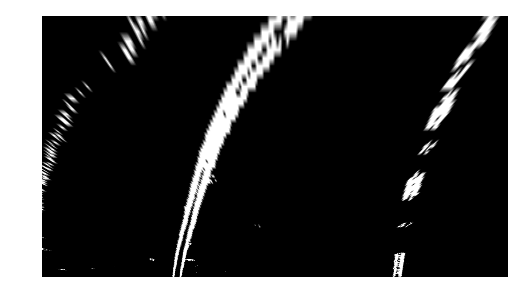

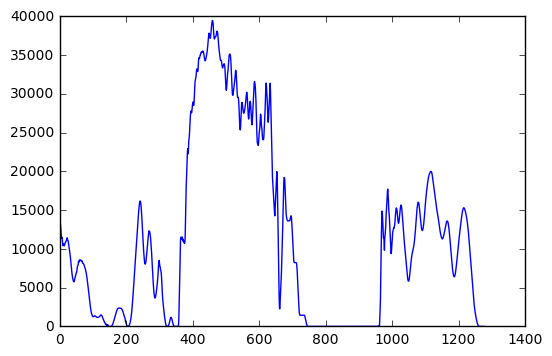

In [208]:
window = np.ones(35)

plt.imshow(warped, cmap='gray'); plt.axis('off'); 
plt.show();

total_sum = np.sum(warped, axis=0)
plt.plot(total_sum)
plt.show();

We can see two major peaks - one on the left, representing the left lane lane, and one on the right, representing the right lane line.  We identify the centers of these peaks and start at the corresponding point in the warped image. We then move up and down, and left and right within certain acceptable limits, identifying the next possible set of pixels that might form part of the lane line.

This is done in the method below (credit: P4 Tutorial Video, Udacity)

In [209]:
class tracker():
    def __init__(self, Mywindow_width, Mywindow_height, Mymargin, Mysmooth_factor = 15):
        
        self.recent_centers = []
        self.window_width = Mywindow_width
        self.window_height = Mywindow_height
        self.margin = Mymargin
        self.smooth_factor = Mysmooth_factor
        
    def find_window_centroids(self, warped):
        
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        
        window_centroids = []
        window = np.ones(window_width)
        
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(warped.shape[1]/2)
        
        window_centroids.append((l_center, r_center))
        
        for level in range(1, (int)(warped.shape[0]/window_height)):
            image_layer = np.sum(warped[int(warped.shape[0] - (level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            offset = window_width/2
            l_min_index = int(max(l_center + offset - margin, 0))
            l_max_index = int(min(l_center + offset + margin, warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
            
            r_min_index = int(max(r_center + offset - margin, 0))
            r_max_index = int(min(r_center + offset + margin, warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index: r_max_index]) + r_min_index - offset
            
            window_centroids.append((l_center, r_center))
            
        self.recent_centers.append(window_centroids)
        
        return np.average(self.recent_centers[-self.smooth_factor:], axis = 0)

In [210]:
window_width = 35
window_height = 80
curve_centers = tracker(Mywindow_width = 35, Mywindow_height = 80, Mymargin = 50, Mysmooth_factor = 100)

window_centroids = curve_centers.find_window_centroids (warped)

l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)

leftx = []
rightx = []

for level in range(0, len(window_centroids)):

    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])

    l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
    r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)

    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

template = np.array(r_points + l_points, np.uint8)
zero_channel = np.zeros_like(template)
template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
warpage = np.array(cv2.merge((warped, warped, warped)), np.uint8)
detected_lanes = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)

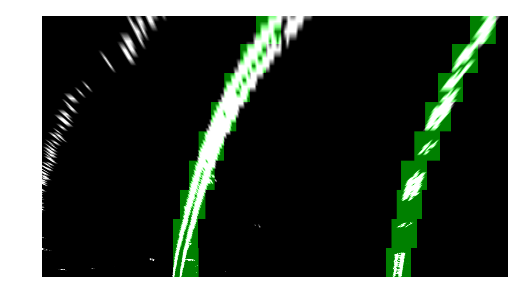

In [213]:
showImage(detected_lanes)
plt.imsave("./output_images/step_3_line_detection.jpg", detected_lanes)

##### Fitting the polynomial

Next, I fit a polynomial to the curve:

In [214]:
yvals = range(0, warped.shape[0])
res_yvals = np.arange(warped.shape[0] - (window_height/2), 0, -window_height)

left_fit, left_res, _, _, _ = np.polyfit(res_yvals, leftx, 2, full=True)
right_fit, right_res, _, _, _ = np.polyfit(res_yvals, rightx, 2, full=True)

##### Bayesian Informing for averaging

Next, I used the MSE of the fit to inform a weighted average across successive frames.

In [215]:
# INITIALIZE VALUES - These change with every passing frame
previous_left_MSE = float('inf')
previous_right_MSE = float('inf')
previous_left_poly = np.zeros(shape=(3))
previous_right_poly = np.zeros(shape=(3))

In [216]:
left_MSE = np.mean(left_res) 
right_MSE = np.mean(right_res)

#Bayesian informing
k = left_MSE/(left_MSE + previous_left_MSE)
left_fit = k*previous_left_poly + (1-k)*left_fit

k = right_MSE/(right_MSE + previous_right_MSE)
right_fit = k*previous_right_poly + (1-k)*right_fit

if previous_right_MSE < float('inf'):
    previous_right_MSE = k*previous_right_MSE + (1-k)*right_MSE
else:
    previous_right_MSE = right_MSE   
previous_right_poly = right_fit

if previous_left_MSE < float('inf'):
    previous_left_MSE = k*previous_left_MSE + (1-k)*left_MSE
else:
    previous_left_MSE = left_MSE   
previous_left_poly = left_fit

Next, we generate x values for the corresponding fit

In [217]:
left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
left_fitx = np.array(left_fitx, np.int32)

right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
right_fitx = np.array(right_fitx, np.int32)

left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis = 0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)
inner_lane = np.array(list(zip(np.concatenate((left_fitx + window_width/2, right_fitx[::-1] - window_width/2), axis=0), np.concatenate((yvals, yvals[::-1]), axis = 0))), np.int32)

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


And draw the fitted curve:

In [218]:
def draw_road_lanes(image, left_lane, inner_lane, right_lane, M_inv):
    road = np.zeros_like(image)
    road_bg = np.zeros_like(image)
    
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road, [inner_lane], color=[0,0,255])
    cv2.fillPoly(road_bg, [left_lane], color = [255, 255, 255])
    cv2.fillPoly(road_bg, [right_lane], color = [255, 255, 255])
    
    road_warped = cv2.warpPerspective(road, M_inv, (image.shape[1], image.shape[0]), flags = cv2.INTER_LINEAR)
    road_warped_bg = cv2.warpPerspective(road_bg, M_inv, (image.shape[1], image.shape[0]), flags = cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(image, 1.0, road_warped_bg, -1.0, 0.0)
    result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)
    
    return result

In [219]:
img = cv2.undistort(plt.imread("./test_images/test3.jpg"), mtx, dist, None, mtx)
result = draw_road_lanes(img, left_lane, inner_lane, right_lane, M_inv)

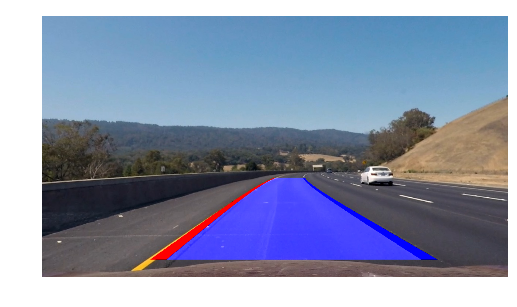

In [220]:
showImage(result)
plt.imsave("./output_images/step_4_result.jpg", result)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in the last 10 lines of the fit_lanes method in my `Advanced Lane Lines Project.ipynb` notebook

Firstly I fit a second order polynomial (curve) to the left lane. I then used this fitted curve to calculate the angle of the left lane line's curvature.
<br><br>
This curvature was calculated using the formula yielded by the tutorial on http://www.intmath.com/applications-differentiation/8-radius-curvature.php. (See below)<br><br>
I based the calculation on the assumption that the lane is about 30 meters long and 3.7 meters wide (as specified in the Udacity classroom). 

##### The formula

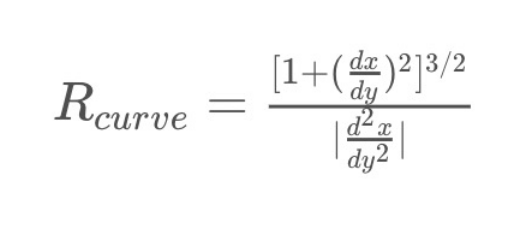

In [196]:
plt.imshow(plt.imread("./R_curve_orig.jpg")); plt.axis('off'); plt.show();

For a second order polynomial, we have that the first and second derivatives are:

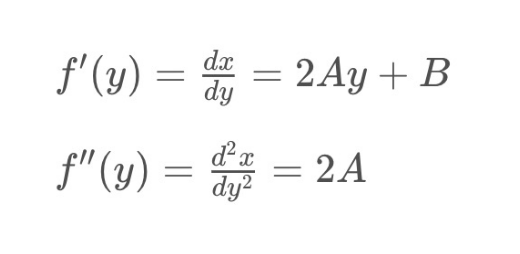

In [197]:
plt.imshow(plt.imread("./derivatives.jpg")); plt.axis('off'); plt.show();

Hence:

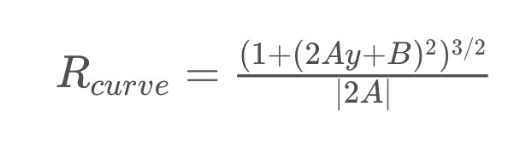

In [198]:
plt.imshow(plt.imread("./R_curve.jpg")); plt.axis('off'); plt.show();

In [199]:
#Assuming the lane is about 30 meters long and 3.7 meters wide:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space (fit to left curve)
corner_curve = np.polyfit(x = np.array(res_yvals, np.float32)*ym_per_pix, 
                          y = np.array(leftx, np.float32)*xm_per_pix, 
                          deg = 2)

# Calculate the new radii of curvature
curve_radians = ((1 + (2*corner_curve[0]*yvals[-1]*ym_per_pix + corner_curve[1])**2)**1.5) / np.absolute(2*corner_curve[0])

Next, we need to calculate the position of the vehicle with respect to the center.
<br>  This simply involves using the middle of the x-intercepts of the two curves and calculating the distance of that from the center of the image (ie the center of the camera). That way we know have far our camera center is from the center of the lane.

In [200]:
camera_center = (left_fitx[-1] + right_fitx[-1])/2
camera_lane_diff = (camera_center-result.shape[1]/2)*xm_per_pix
pos = 'left'
if camera_lane_diff < 0:
    pos = "right"

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in the last 10 lines of my code in `Advanced Lane Lines Project.ipynb` in the function `map_lane()`.  Here is an example of my result on a test image:

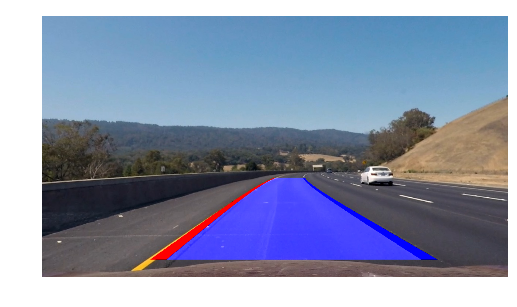

Radius of Curvature = 396.769
0.219m left of center


In [201]:
showImage(result)
print('Radius of Curvature = ' + str(round(curve_radians, 3)))
print(str(abs(round(camera_lane_diff, 3))) + 'm ' + pos + ' of center')

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video_output.mp4)<br>
Here's a [link to a video of the pipeline in action!](./project_video_output_show_pipeline.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

This was a challenging project in the sense that there are so many parameters to tune, and tuning one parameter affects the rest of the pipeline as well. I spent way too much time tuning and playing with parameters, and ultimately had to follow the Udacity tutorial and redo the project from scratch with a more well thought-out approach.
<br><br>
The approach is likely to fail in strange light situations, i.e. a very bright road or a lot of shade, etc. It will also fail under different coloured road lines (like my country, South Africa, for example often has red left lanes, which would probably be rejected by the colour filters).
<br><br>
It could be made more robust by building the ability to handle different conditions. I.e. adjusting the filters / how harsh they are based on the lighting situation of the images. <br>
There are other techniques as well for making the pipeline more robust. Localisation to a map, for example, to get a prior distribution of where the lanes might be and in what direction they're most probably curving would help improve accuracy by a long shot. <br><br>
Another - easier implementable - technique could be to align the two lane lines. It is often the case that the left line isn't detected correctly, while the right lane line is (or vice versa). A more robust pipeline could identify which lane line "signal" is strongest and use that to infer the direction of both lane lines together - instead of one lane staying on course and the other drifting off.
